## Análisis Exploratorio de los datos (EDA)

### 1 - OBTENEMOS LOS ARCHIVOS DE GOOGLE CLOUD PLATFORM PARA LA EXPLORACION

**Importamos las librerias necesarias**

In [175]:
#!pip install google-cloud-bigquery
#!pip install --upgrade google-cloud-bigquery
#!pip install db-dtypes


In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)


In [2]:
#Importa la biblioteca google.cloud.bigquery para interactuar con BigQuery
from google.cloud import bigquery

#Importa la biblioteca google.oauth2 para manejar la autenticación
from google.oauth2 import service_account

**Conectamos con la base de datos de bigQuery**

In [3]:
#Configura las credenciales de autenticación

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../Clave_cloud.json"

In [4]:
# Crea un cliente de BigQuery
cliente = bigquery.Client()

In [5]:
# Query para obtener la tabla de Business unida con categorias , atributos, Horarios
query1 = """
SELECT B.city, B.id_business, B.latitude, B.longitude, B.name, B.review_count, B.stars, B.state,
A.Descripcion, C.Descripcion, BH.hours, T.compliment_count, T.Date
FROM `ds_yelp.Business` AS B
LEFT JOIN ds_yelp.DetalleAtributos AS DT ON B.id_business = DT.id_business
LEFT JOIN ds_yelp.Atributos AS A ON DT.IdAtributos = A.IdAtributos
LEFT JOIN ds_yelp.DetalleCategorias AS DC ON B.id_business = DC.id_business
LEFT JOIN ds_yelp.Categorias AS C ON DC.IdCategoria = C.IdCategoria
LEFT JOIN ds_yelp.DetallesHora AS DH ON B.id_business = DH.id_business
LEFT JOIN ds_yelp.BusinessHoras AS BH ON DH.id_business = BH.id_business
LEFT JOIN ds_yelp.Tips AS T ON B.id_business = T.id_business
LIMIT 10
"""

**Obtenemos el dataframe de Business unido con Categorias, Atributos, Horarios y Tips**

In [6]:
# Ejecuta la consulta
query_job = cliente.query(query1)

# Inicializa una lista para almacenar las filas
rows = []

# Recorre los resultados y agrega cada fila a la lista
for row in query_job:
    rows.append(row)

# Convierte la lista de filas en un DataFrame
df_business = pd.DataFrame(rows)

**El dataframe es un archivo separado por comas por lo cual lo expandimos**

In [7]:
import pandas as pd

def expand_dataframe_row(row):
    expanded_row = []
    values = row[0]
    for value in values:
        if isinstance(value, dict):
            expanded_row.extend(list(value.values()))
        elif isinstance(value, tuple):
            expanded_row.extend(list(value))
        else:
            expanded_row.append(value)
    return expanded_row

def expand_dataframe(df):
    expanded_data = [expand_dataframe_row(row) for row in df.values]
    expanded_df = pd.DataFrame(expanded_data)
    return expanded_df

# aplicamos laf funcion
df_business_expandido = expand_dataframe(df_business)

In [8]:
# Definir los nombres de columna deseados
nombres_columnas = ['city', 'id_business', 'latitude', 'longitude', 'name', 'review_count', 'stars', 'state',
                    'Descripcion_atributo', 'Descripcion_Categoria', 'horario', 'compliment_count', 'Date']

# Asignar los nombres de columna al DataFrame
df_business_final = df_business_expandido.rename(columns=dict(zip(df_business_expandido.columns, nombres_columnas)))

In [9]:
df_business_final.head()

,city,id_business,latitude,longitude,name,review_count,stars,state,Descripcion_atributo,Descripcion_Categoria,horario,compliment_count,Date
0,Waco,8099,39.76504,-74.890892,Domino's Pizza,7,2.0,Texas,RestaurantsPriceRange2: 1,Restaurants,"{'Monday': '10:30-0:0', 'Tuesday': '10:30-0:0', 'Wednesday': '10:30-0:0', 'Thursday': '10:30-0:0', 'Friday': '10:30-1:0', 'Saturday': '10:30-1:0', 'Sunday': '10:30-0:0'}",0,2014-02-15 12:19:02+00:00
1,Waco,8099,39.76504,-74.890892,Domino's Pizza,7,2.0,Texas,RestaurantsPriceRange2: 1,Restaurants,"{'Monday': '10:30-0:0', 'Tuesday': '10:30-0:0', 'Wednesday': '10:30-0:0', 'Thursday': '10:30-0:0', 'Friday': '10:30-1:0', 'Saturday': '10:30-1:0', 'Sunday': '10:30-0:0'}",0,2014-02-15 12:19:02+00:00
2,Waco,8099,39.76504,-74.890892,Domino's Pizza,7,2.0,Texas,RestaurantsPriceRange2: 1,Restaurants,"{'Monday': '10:30-0:0', 'Tuesday': '10:30-0:0', 'Wednesday': '10:30-0:0', 'Thursday': '10:30-0:0', 'Friday': '10:30-1:0', 'Saturday': '10:30-1:0', 'Sunday': '10:30-0:0'}",0,2014-02-15 12:19:02+00:00
3,Waco,8099,39.76504,-74.890892,Domino's Pizza,7,2.0,Texas,RestaurantsPriceRange2: 1,Restaurants,"{'Monday': '10:30-0:0', 'Tuesday': '10:30-0:0', 'Wednesday': '10:30-0:0', 'Thursday': '10:30-0:0', 'Friday': '10:30-1:0', 'Saturday': '10:30-1:0', 'Sunday': '10:30-0:0'}",0,2014-02-15 12:19:02+00:00
4,Waco,8099,39.76504,-74.890892,Domino's Pizza,7,2.0,Texas,RestaurantsPriceRange2: 1,Restaurants,"{'Monday': '10:30-0:0', 'Tuesday': '10:30-0:0', 'Wednesday': '10:30-0:0', 'Thursday': '10:30-0:0', 'Friday': '10:30-1:0', 'Saturday': '10:30-1:0', 'Sunday': '10:30-0:0'}",0,2014-02-15 12:19:02+00:00


## 2- Generación de tabla de Reviews (YELP)

**Obtenemos el dataframe Reviews unido con Business y Usuario**

In [6]:
# Query para obtener la tabla de Review unida con Business y usuario
query2 = """
SELECT R.cool, R.date, R.funny, R.stars, R.text, R.useful, B.name, B.city, B.state,
U.average_stars, U.compliment_cool, U.compliment_cute, U.compliment_funny, U.compliment_hot, U.compliment_list,
U.compliment_more, U.compliment_note, U.compliment_photos, U.compliment_plain, U.compliment_profile, U.compliment_writer,
U.cool, U.funny, U.useful
FROM `ds_yelp.Review` AS R
LEFT JOIN ds_yelp.Business AS B ON R.id_business = B.id_business
LEFT JOIN ds_yelp.Usuario AS U ON R.id_user = U.id_user
LIMIT 5
"""

In [7]:
# Ejecuta la consulta
query_job = cliente.query(query2)

# Recupera los resultados como una lista de diccionarios
rows = [dict(row) for row in query_job]

# Convierte la lista de diccionarios en un DataFrame de Pandas
df_review = pd.DataFrame(rows)


In [ ]:
df_review.head(1)

**Exporto el df_review para la exploración**

In [184]:
df_review.to_csv('df_review_combinado.csv', index=False)

**Descarga de archivos individuales**

**Archivo Business**

In [14]:
# Query para obtener la tabla de Business
query3 = """
SELECT city, id_business, latitude, longitude, name, review_count, stars, state,
FROM `ds_yelp.Business`
LIMIT 10
"""

In [15]:
# Ejecuta la consulta
query_job = cliente.query(query3)

# Recupera los resultados como una lista de diccionarios
rows = [dict(row) for row in query_job]

# Convierte la lista de diccionarios en un DataFrame de Pandas
df_business = pd.DataFrame(rows)

In [16]:
df_business

,city,id_business,latitude,longitude,name,review_count,stars,state
0,Waco,8099,39.765040,-74.890892,Domino's Pizza,7,2.0,Texas
1,Waco,53235,40.080281,-75.167319,Hibachi Grill & Supreme Buffet,19,2.0,Texas
2,Waco,59185,40.075802,-75.159403,KFC,13,2.0,Texas
3,Waco,63073,40.081806,-75.167837,Empire Beauty School,5,2.0,Texas
4,Waco,75807,39.768259,-74.894218,Gel Nails and Spa,10,2.0,Texas
5,Waco,94314,40.081647,-75.162088,Towers at Wyncote,37,2.0,Texas
6,Waco,96370,40.081290,-75.169774,Golden Corral Buffet & Grill,22,2.0,Texas
7,Waco,114853,40.074353,-75.152827,The Home Depot,48,2.0,Texas
8,Waco,116449,39.769788,-74.887946,White Horse Tree Care,5,2.0,Texas
9,Waco,123076,40.075451,-75.159761,Walgreens,6,2.0,Texas


In [20]:
##Exporto el archivo
df_business.to_csv('df_business.csv', index=False)

**Archivo review**

In [17]:
# Query para obtener la tabla de review
query4 = """
SELECT cool, date, funny, stars, text, useful
FROM `ds_yelp.Review`
LIMIT 10
"""

In [18]:
# Ejecuta la consulta
query_job = cliente.query(query4)

# Recupera los resultados como una lista de diccionarios
rows = [dict(row) for row in query_job]

# Convierte la lista de diccionarios en un DataFrame de Pandas
df_review = pd.DataFrame(rows)

In [ ]:
df_review.to_csv('df_review.csv', index=False)

**Archivo usuario**

In [20]:
# Query para obtener la tabla de usuario
query5 = """
SELECT average_stars, compliment_cool, compliment_cute, compliment_funny, compliment_hot, compliment_list,
compliment_more, compliment_note, compliment_photos, compliment_plain, compliment_profile, compliment_writer,
cool, funny, useful
FROM `ds_yelp.Usuario`
LIMIT 10
"""

In [21]:
# Ejecuta la consulta
query_job = cliente.query(query5)

# Recupera los resultados como una lista de diccionarios
rows = [dict(row) for row in query_job]

# Convierte la lista de diccionarios en un DataFrame de Pandas
df_usuario= pd.DataFrame(rows)

In [ ]:
df_usuario.to_csv('df_usuario.csv', index=False)

**Archivo Atributos con Business**

In [22]:
# Query para obtener la tabla de usuario
query6 = """
SELECT A.Descripcion, DA.id_business
FROM `ds_yelp.DetalleAtributos` AS DA
LEFT JOIN ds_yelp.Atributos AS A ON DA.IdAtributos = A.IdAtributos
"""

In [23]:
# Ejecuta la consulta
query_job = cliente.query(query6)

# Recupera los resultados como una lista de diccionarios
rows = [dict(row) for row in query_job]

# Convierte la lista de diccionarios en un DataFrame de Pandas
df_atributos= pd.DataFrame(rows)

In [24]:
df_atributos.to_csv('df_atributos.csv', index=False)

**Archivo Categorías con Business**

In [25]:
query7 = """
SELECT C.Descripcion, DC.id_business
FROM `ds_yelp.DetalleCategorias` AS DC
LEFT JOIN ds_yelp.Categorias AS C ON DC.IdCategoria = C.IdCategoria
"""

In [26]:
# Ejecuta la consulta
query_job = cliente.query(query7)

# Recupera los resultados como una lista de diccionarios
rows = [dict(row) for row in query_job]

# Convierte la lista de diccionarios en un DataFrame de Pandas
df_categorias= pd.DataFrame(rows)

In [27]:
df_categorias.to_csv('df_categorias.csv', index=False)

**Archivo Horarios**

In [40]:
query8 = """
SELECT BH.hours, DH.id_business
FROM `ds_yelp.DetallesHora` AS DH
LEFT JOIN ds_yelp.BusinessHoras AS BH ON DH.id_business = BH.id_business
"""

In [41]:
# Ejecuta la consulta
query_job = cliente.query(query8)

# Recupera los resultados como una lista de diccionarios
rows = [dict(row) for row in query_job]

# Convierte la lista de diccionarios en un DataFrame de Pandas
df_Horarios= pd.DataFrame(rows)

In [42]:
df_Horarios.to_csv('df_horarios.csv', index=False)

**Archivo Tips**

In [44]:
query9 = """ SELECT * FROM `ds_yelp.Tips` """

In [45]:
# Ejecuta la consulta
query_job = cliente.query(query9)

# Recupera los resultados como una lista de diccionarios
rows = [dict(row) for row in query_job]

# Convierte la lista de diccionarios en un DataFrame de Pandas
df_Tips= pd.DataFrame(rows)

In [46]:
df_Tips.to_csv('df_tips.csv', index=False)

### 2- Analisis Exploratorio de los datos

**2.1-Exploramos los datos de Review unida con review y business**

**Importamos las librerias necesarias**

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud
import ast

**Cargamos el dataframe de review**

In [9]:
df_review_combinado = pd.read_csv("../NOTEBOOK_ETL/ARCHIVOS PARA EDA/df_review_combinado.csv")

**Exploramos aspectos generales del dataframe**

In [22]:
##Filtro el dataframe
columnas = ["name", "city", "state", "cool", "date", "funny", "stars", "text", "useful"]
df_review_filtrado = df_review_combinado[columnas]
df_review_filtrado[["cool", "funny", "useful", "stars"]] = df_review_filtrado[["cool", "funny", "useful", "stars"]].abs()

C:\Users\nany_\AppData\Local\Temp\ipykernel_25128\3940898336.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review_filtrado[["cool", "funny", "useful", "stars"]] = df_review_filtrado[["cool", "funny", "useful", "stars"]].abs()


In [11]:
df_review_filtrado.columns

Index(['name', 'city', 'state', 'cool', 'date', 'funny', 'stars', 'text',
       'useful'],
      dtype='object')

In [8]:
#Exploramos las dimensiones del dataframe
df_review_filtrado.shape

(2783304, 9)

In [72]:
#Revisamos que tipo de dato es cada columna
df_review_filtrado.dtypes

name      object
city      object
state     object
cool       int64
date      object
funny      int64
stars      int64
text      object
useful     int64
dtype: object

In [9]:
#Comprobamos si hay nulos en el dataframe
df_review_filtrado.isnull().sum()

name      0
city      0
state     0
cool      0
date      0
funny     0
stars     0
text      0
useful    0
dtype: int64

**Análisis descriptivo**

*En la descripción general de las variables numericas podemos evidenciar estadisticos importantes como: la media, la desviación estandar, los cuartiles(0.25,0.5,0.75), el valor maximo y minimo de cada columna:*

In [ ]:
#Describimos las variables numericas de forma general
df_review_filtrado.describe(include=[np.number])

In [23]:
#Describimos las variables de tipo categorico
columnas = ["name", "city", "state", "date"]
df_review_filtrado[columnas].describe(include=object)

,name,city,state,date
count,2783304,2783304,2783304,2783304
unique,47879,114,5,2766356
top,Starbucks,Philadelphia,Pennsylvania,2014-04-14 09:19:21+00:00
freq,8317,971081,995698,7


In [30]:
#Hacemos una copia solo con las columnas involucradas en el engagement
df_reviewfinal = df_review_filtrado[["city", "state", "date", "name", "cool", "funny", "useful", "text"]].copy()
df_reviewfinal.loc[:, "Engagement"] = df_reviewfinal["cool"] + df_reviewfinal["funny"] + df_reviewfinal["useful"]

**Revisamos valores atipicos**

*Basado en los resultados obtenidos sobre los outliers en cada columna de tu DataFrame de reseñas de Yelp, podemos sacar algunas conclusiones intrigantes:*

* *En primer lugar, la columna "Cool" revela algo fascinante. Con un asombroso número de 628,915 outliers, parece que algunas reseñas han sido consideradas excepcionalmente interesantes. Estas reseñas han recibido una cantidad inusualmente alta de votos "cool". Es como si hubieran despertado la admiración de los lectores y se hayan ganado su respeto.*

* *Por otro lado, la columna "Funny" nos lleva por un camino divertido. Aquí encontramos 448,109 outliers, lo que significa que algunas reseñas han sido calificadas como extremadamente graciosas. Estas reseñas han conseguido arrancar risas y sonrisas a los lectores, dejándolos con una sensación de alegría y diversión.*

* *En cuanto a la columna "Stars", podemos confirmar que no se detectaron outliers. Esto no es sorprendente, ya que las calificaciones de las reseñas en Yelp están predeterminadas para estar dentro del rango de 1 a 5 estrellas.*

* *El análisis realizado reveló la presencia de 244,709 outliers en la métrica de engagement. Estos outliers indican que algunos negocios están experimentando una conexión emocional excepcionalmente fuerte con sus clientes. Esos negocios pueden estar generando reseñas extremadamente positivas o recibiendo una cantidad significativa de votos "cool", "funny" y "useful".**

* *Finalmente, en la columna "Useful" nos encontramos con 372,640 outliers. Estos outliers nos indican que algunas reseñas han sido consideradas extremadamente útiles por los usuarios. Han recibido una gran cantidad de votos "útil", lo que implica que han proporcionado información valiosa y orientación a aquellos que las han leído.*

In [31]:
# Obtener columnas numéricas
columnas_numericas = df_reviewfinal.select_dtypes(include=[np.number])

# Calcular el rango intercuartílico (IQR) para cada columna numérica
q1 = columnas_numericas.quantile(0.25)
q3 = columnas_numericas.quantile(0.75)
iqr = q3 - q1

# Calcular la mediana (quartil 0.5)
mediana = columnas_numericas.median()

# Definir los límites superior e inferior para detectar outliers
umbral_superior = q3 + 1.5 * iqr
umbral_inferior = q1 - 1.5 * iqr

# Detectar outliers en cada columna numérica
outliers = ((columnas_numericas < umbral_inferior) | (columnas_numericas > umbral_superior))

# Obtener el número de outliers en cada columna
num_outliers = outliers.sum()

# Obtener la cantidad de valores por debajo del mínimo y por encima del máximo para cada columna
valores_por_debajo_min = (columnas_numericas < umbral_inferior).sum()
valores_por_encima_max = (columnas_numericas > umbral_superior).sum()

# Obtener los umbrales mínimo y máximo por columna
umbral_minimo = columnas_numericas.min()
umbral_maximo = columnas_numericas.max()

# Crear una tabla con los resultados
tabla_resultados = pd.DataFrame({
    "Número de outliers": num_outliers,
    "Valores por debajo del mínimo": valores_por_debajo_min,
    "Valores por encima del máximo": valores_por_encima_max,
    "Umbral mínimo": umbral_minimo,
    "Umbral máximo": umbral_maximo,
    "Mediana": mediana
})

# Imprimir la tabla de resultados
print(tabla_resultados)

            Número de outliers  Valores por debajo del mínimo  \
cool                    628915                              0   
funny                   448109                              0   
useful                  372640                              0   
Engagement              244709                              0   

            Valores por encima del máximo  Umbral mínimo  Umbral máximo  \
cool                               628915              0            207   
funny                              448109              0            284   
useful                             372640              0            320   
Engagement                         244709              0            593   

            Mediana  
cool            0.0  
funny           0.0  
useful          0.0  
Engagement      1.0  


Revisamos los negocios involucrados en los outliers o casos excepcionales para cool, funny, useful y stars

In [32]:
filas_con_outliers = outliers.any(axis=1)
Negocios_con_outliers = df_reviewfinal[filas_con_outliers]

In [33]:
##Filtro columnas que me interesan para el Engagement
Negocios_con_outliers = Negocios_con_outliers[["city", "state","date", "name", "cool", "funny", "useful", "Engagement"]]
## Dejo los valores en positivo
Negocios_con_outliers[["cool", "funny", "useful"]] = Negocios_con_outliers[["cool", "funny", "useful"]].abs()

In [35]:
#Exporto el archivo para engagement
Negocios_con_outliers.to_csv("Negocios_MayorEngagement.csv", index=False)

**Hacemo un Pairplot para visualizar la distribucion de los datos**

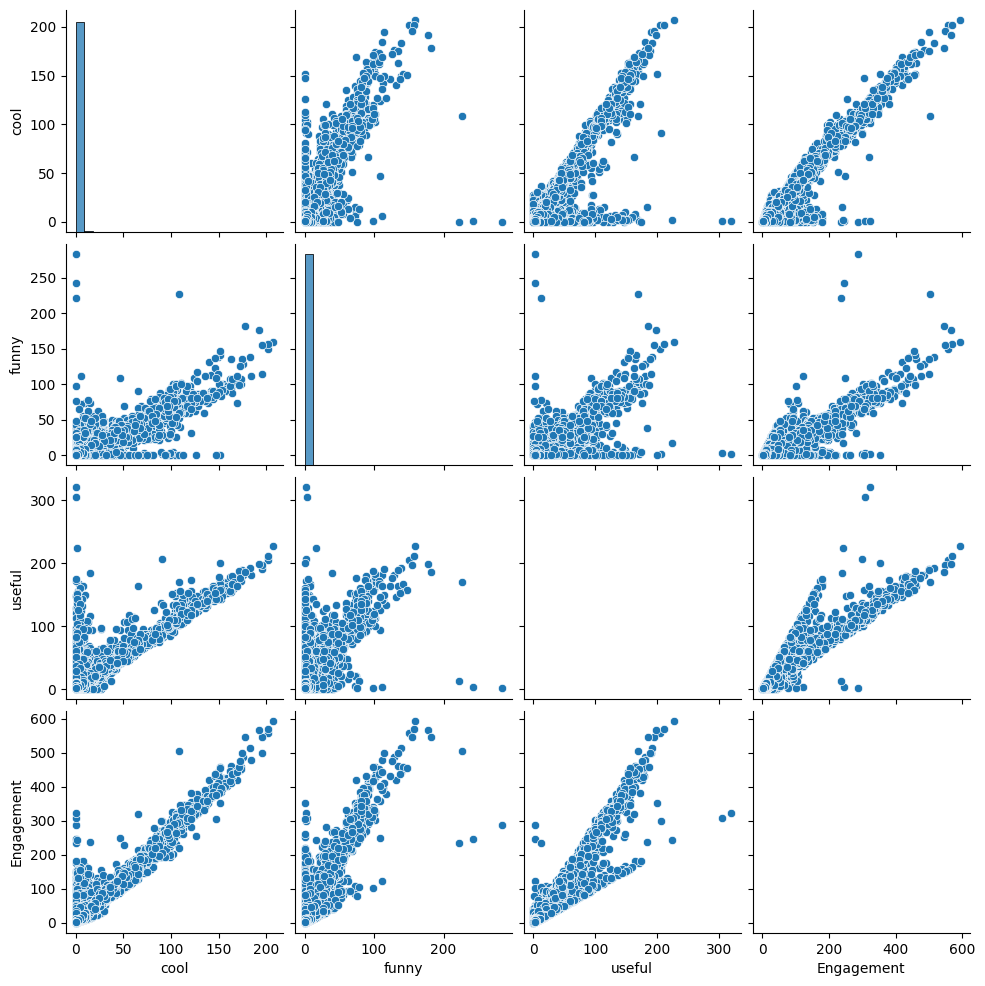

In [31]:
# Plot pairplot
sns.pairplot(df_reviewfinal)

# Display the plot
plt.show()

**Hacemos un Heatmeap para conocer las relaciones**

C:\Users\nany_\AppData\Local\Temp\ipykernel_22556\3710309008.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_reviewfinal.corr()


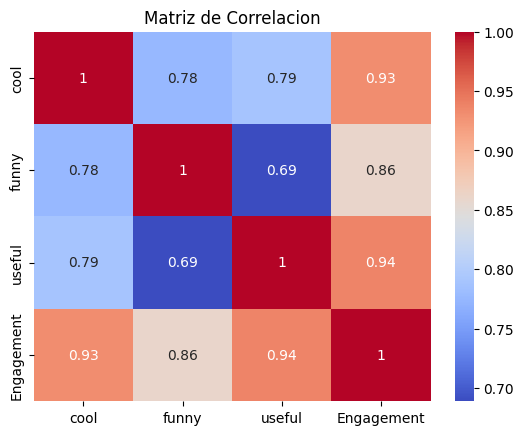

In [32]:
# Calculate correlation matrix
corr_matrix = df_reviewfinal.corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

# Titulo
plt.title("Matriz de Correlacion")

# Display the plot
plt.show()


**2.2-Exploramos los negocios**

In [110]:
df_combinado_business = pd.read_csv("./ARCHIVOS PARA EDA/df_business.csv", sep=",")

In [111]:
df_combinado_business.columns

Index(['city', 'id_business', 'latitude', 'longitude', 'name', 'review_count',
       'stars', 'state'],
      dtype='object')